# Exam paper: Optimal Energy mix in Nuuk, Greenland

We import the basic packages:

In [1411]:
%run stdPackages.ipynb

In [1412]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1413]:
from pyDbs import *
from IPython.display import Image
figs_path = os.path.join(d['curr'],'Figs')


We create a path to data

In [1414]:
import os 
path_to_data = os.path.join(d['curr'],'Data','EE_exam data_version2.xlsx')
print(path_to_data)

c:\Users\CAAL\OneDrive - COWI\Desktop\Nuuk-Energy-mix\Exercises\E44\Data\EE_exam data_version2.xlsx


In [1415]:
kwargs = {'variables': ['Fundamentals', 'Load', 'Generators_Other'],
        'maps': ['Generators_Categories','hMaps'],
        'variable2D': ['HourlyVariation','Generators_FuelMix', 'Precipitation'],
        'scalars': ['Scalars']}

db = read.dbFromWB(path_to_data, kwargs)
readSets(db)

__Control__

Finally, we make sure our code is correct by solving for the baseline scenario, where this is no storage:

In [1416]:
from Exam import *
m = mSimple(db)
m()

Solution status 0: Optimization terminated successfully. (HiGHS Status 7: Optimal)


We control if we leave _charge_ out of the model, since we set it exogeniously

In [1417]:
m.db.symbols.keys()

dict_keys(['EmissionTax', 'FuelPrice', 'EmissionIntensity', 'Load', 'LoadVariation', 'sCap', 'effS', 'OtherMC', 'GeneratingCapacity', 'id2tech', 'id2hvt', 'h2Weekday', 'h2HourOfTheDay', 'h2Week', 'h2Month', 'CapVariation', 'FuelMix', 'Precipitation', 'MWP', 'hydro_scalar', 'EmissionType', 'BFt', 'c', 'h', 'id', 'hvt', 'h_constr', 'id_constr', 'mc', 'discharge', 'HourlyDemand', 'Generation', 'stored', 'λ_LawOfMotion', 'λ_equilibrium', 'λ_discharge', 'λ_HourlyDemand', 'λ_Generation', 'λ_stored', 'Welfare', 'meanConsumerPrice', 'capacityFactor', 'marginalSystemCosts', 'marginalEconomicValue', 'capturePrice', 'marketValueFactor', 'consumerSurplus', 'producerSurplus'])

Save solution for later:

In [1418]:
base_db = m.db.copy()

In the following, we aggregate the fuel types to the following types:

In [1419]:
agg_BFt = {
    'Fueloil':'Oil','Gasoil':'Oil', 
    'Straw':'Biomass','WoodPellets':'Biomass','WoodChips':'Biomass','WoodWaste':'Biomass',
    'Biogas':'Other Bio','BioOil':'Other Bio',
    'Coal':'Coal',
    'NatGas':'Natural gas',
    'Waste':'Waste'
}

# The optimal combination of wind and hydro

First, we define the vectors. 

Since Buksefjordsværket in Nuuk already has a capacity of 45 MW, and the planned expantion of the hydro power plant is 55 MW (in all 100 MW), the vector of hydro goes from 45 to 100. 

Thus, the vector of wind goes from 0 to 100 MW.. 

Each vector contains five points, and so we have 25 combinations of hydro and wind.

In [1420]:
# Defining vectors for wind and hydro
vec_hydro = np.linspace(45, 100, 5)
vec_wind = np.linspace(0, 100, 5)

# printing vectors
print("Vector for hydro:", vec_hydro)
print("Vector for wind:", vec_wind)

Vector for hydro: [ 45.    58.75  72.5   86.25 100.  ]
Vector for wind: [  0.  25.  50.  75. 100.]


### __Electricity__

Secondly, we create two dataframes representing electricity capacity of hydro and wind, respectively. 

In [1421]:
# defining of minimum electricity
min_elec = [vec_hydro[0], vec_wind[0]]

# definition of max electricity
max_elec = [vec_hydro[4], vec_wind[4]]

# Defining the loop
loop = pd.RangeIndex(25, name='loop')

# lower and upper bound for hydro
v0_ECap_Hydro = pd.Series(min_elec[0], index=getTechs(['Storage'], m.db))
vT_ECap_Hydro = pd.Series(max_elec[0], index=getTechs(['Storage'], m.db))

# Grid for hydro
grid_ECap_Hydro = pd.Series([vec_hydro[i] for i in range(5) for _ in range(5)], index=pd.MultiIndex.from_product([loop, [db['id'][-1]]], names=['loop', 'id']), name='GeneratingCapacity')

# lower and upper bound for wind
v0_ECap_Wind = pd.Series(min_elec[1], index=getTechs(['Standard'], m.db))
vT_ECap_Wind = pd.Series(max_elec[1], index=getTechs(['Standard'], m.db))

# grid for wind
grid_ECap_Wind = pd.Series([vec_wind[i] for _ in range(5) for i in range(5)], index=pd.MultiIndex.from_product([loop, [db['id'][0]]], names=['loop', 'id']), name='GeneratingCapacity')


### __Storage__

Third, we create a dataframe representing storage capacity based on the reservior of the hydro power plant

In [1422]:
# The "energy storage to power"-ratio/storage duration 
E2P = 5000

# Defining min storage
min_storage = vec_hydro[0]

# defining max storage
max_storage = vec_hydro[4]

# Defining a storage vector
vec_storage = np.linspace(min_storage, max_storage, 5)*E2P

# defining lower and upper bound for electricity storage by multiplying E2P with the energy production
v0_SCap = pd.Series(min_storage, index = getTechs(['Storage'], m.db))*E2P
vT_SCap = pd.Series(max_storage, index = v0_SCap.index)*E2P

# Second grid with a storage cap running through loop 2
grid_SCap = pd.Series([vec_storage[i] for i in range(5) for _ in range(5)], index=pd.MultiIndex.from_product([loop, db['sCap'].index], names=['loop', 'id']), name='sCap')

### __Scalar of precipitation__ 

Then, we add a scalar of precipitation, as the inflow of water increases, when we increases the surface of the water reservoir.

In [1423]:
# Defining min storage
min_hydro_scalar = 1

# defining max storage
max_hydro_scalar = 3.6

# Defining a storage vector
vec_hydro_scalar = np.linspace(min_hydro_scalar, max_hydro_scalar, 5)

# defining lower and upper bound for electricity storage by multiplying E2P with the energy production
v0_HydroScalar = pd.Series(min_hydro_scalar)
vT_HydroScalar = pd.Series(max_hydro_scalar)

# Second grid with a storage cap running through loop 2
grid_HydroScalar = pd.Series([vec_hydro_scalar[i] for i in range(5) for _ in range(5)], index=loop, name='hydro_scalar')

### __Solving the model__

Then, we extract the relevant variables to solve the model:

In [1460]:
list(m.db.symbols.keys())

['EmissionTax',
 'FuelPrice',
 'EmissionIntensity',
 'Load',
 'LoadVariation',
 'sCap',
 'effS',
 'OtherMC',
 'GeneratingCapacity',
 'id2tech',
 'id2hvt',
 'h2Weekday',
 'h2HourOfTheDay',
 'h2Week',
 'h2Month',
 'CapVariation',
 'FuelMix',
 'Precipitation',
 'MWP',
 'hydro_scalar',
 'EmissionType',
 'BFt',
 'c',
 'h',
 'id',
 'hvt',
 'h_constr',
 'id_constr',
 'mc',
 'discharge',
 'HourlyDemand',
 'Generation',
 'stored',
 'λ_LawOfMotion',
 'λ_equilibrium',
 'λ_discharge',
 'λ_HourlyDemand',
 'λ_Generation',
 'λ_stored',
 'Welfare',
 'meanConsumerPrice',
 'capacityFactor',
 'marginalSystemCosts',
 'marginalEconomicValue',
 'capturePrice',
 'marketValueFactor',
 'consumerSurplus',
 'producerSurplus']

In [1425]:
extract = ['Precipitation', 'CapVariation', 'capturePrice', 'LoadVariation', 'GeneratingCapacity', 'marginalSystemCosts','Generation', 'discharge','capturePrice','marketValueFactor','capacityFactor','marginalEconomicValue','consumerSurplus','producerSurplus','Welfare']

And finally, we solve the model:

In [1426]:
solution = m.loopSolveExtract(loop, [grid_ECap_Hydro, grid_HydroScalar, grid_SCap, grid_ECap_Wind], extract)

### __Results__

In [1427]:
solution['Welfare']

loop
0     1.129032e+07
1     1.599408e+07
2     2.069784e+07
3     2.540160e+07
4     3.006843e+07
5     1.862903e+07
6     2.333279e+07
7     2.803655e+07
8     3.274031e+07
9     3.740714e+07
10    2.596774e+07
11    3.067150e+07
12    3.537526e+07
13    4.007902e+07
14    4.474585e+07
15    3.330645e+07
16    3.801021e+07
17    4.271397e+07
18    4.741773e+07
19    4.943625e+07
20    4.064516e+07
21    4.534892e+07
22    4.881516e+07
23    5.046317e+07
24    5.144900e+07
dtype: float64

In [1428]:
solution['marginalSystemCosts'].groupby('loop').mean()

loop
0     50.000000
1     50.000000
2     50.000000
3     50.000000
4     49.349315
5     50.000000
6     50.000000
7     50.000000
8     50.000000
9     49.349315
10    50.000000
11    50.000000
12    50.000000
13    50.000000
14    49.349315
15    50.000000
16    50.000000
17    50.000000
18    50.000000
19    21.101599
20    50.000000
21    50.000000
22    24.611873
23    18.173517
24    12.813928
dtype: float64

Notice: The code fucked up, and I cannot recall the correct code. However, the code is only used to make a plot, which can be seen in the assigment. 

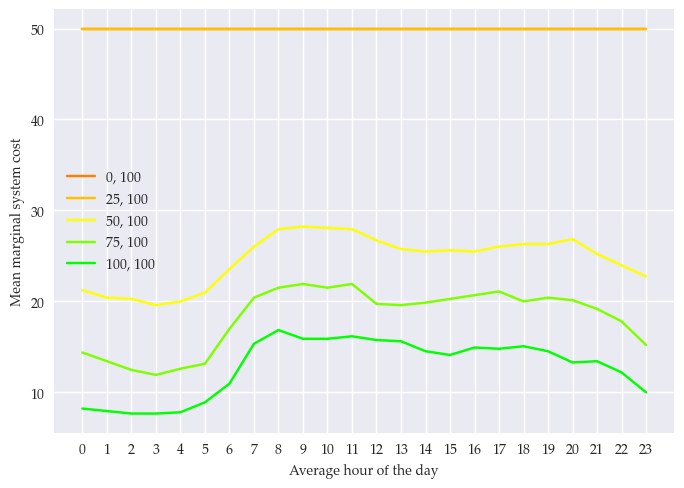

In [1429]:
#test = solution['marginalSystemCosts'].loc[:, 0]
#test = adjMultiIndex.bc(test, db['h2HourOfTheDay']).groupby('HourOfTheDay').mean()
#test2 = solution['marginalSystemCosts'].loc[:, 1]
#test2 = adjMultiIndex.bc(test2, db['h2HourOfTheDay']).groupby('HourOfTheDay').mean()
#pd.concat([test, test2], axis=1)

In [1438]:
solution['marginalSystemCosts'].groupby('loop').mean()

loop
0     50.000000
1     50.000000
2     50.000000
3     50.000000
4     49.349315
5     50.000000
6     50.000000
7     50.000000
8     50.000000
9     49.349315
10    50.000000
11    50.000000
12    50.000000
13    50.000000
14    49.349315
15    50.000000
16    50.000000
17    50.000000
18    50.000000
19    21.101599
20    50.000000
21    50.000000
22    24.611873
23    18.173517
24    12.813928
dtype: float64

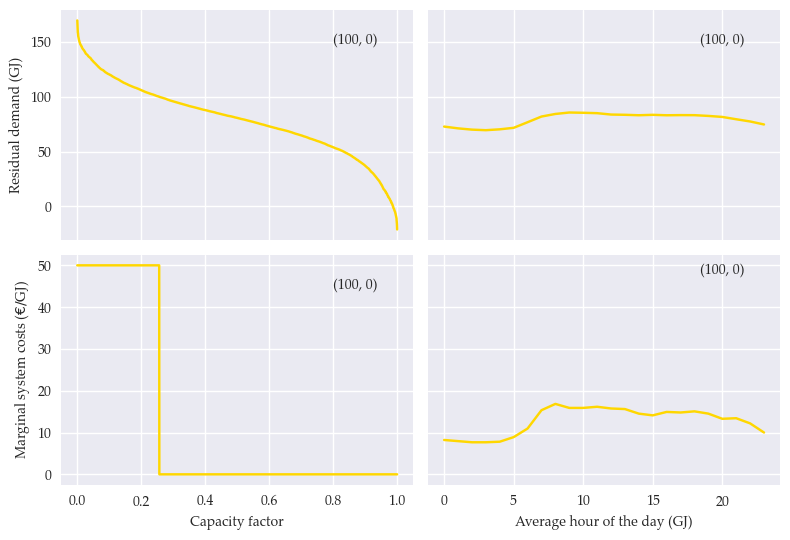

In [1449]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming cmap is defined previously
colors = [(1, 0.5, 0), (1, 1, 0), (0, 1, 0)]  # RGB values for orange, yellow, and green
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

# Make dataframe
int_id = adj.rc_pd(m.db['id2hvt'], pd.Index(['Wind'], name='hvt')).droplevel('hvt')
df_sort = pd.concat([
    adj.rc_pd(m.hourlyGeneratingCap, int_id).groupby('h').sum().rename('E').astype(float),
    m.hourlyLoad.rename('L').astype(float),
    m.db['marginalSystemCosts'].rename('p').astype(float)
], axis=1)

# Calculate residual demand
df_sort['resd'] = df_sort['L'] - df_sort['E']

# Sort dataframe
df_sort = df_sort.sort_values(['resd'], ascending=False).reset_index()
df_sort.index = df_sort.index / len(df_sort)

# Make new dataframe with time mappings
df_h = df_sort.merge(m.db['h2HourOfTheDay'].to_frame(index=False))

# Aggregate for average hour of the day
df_h = df_h.groupby('HourOfTheDay')[['resd', 'p']].mean()

# Make plot
fig, ax = plt.subplots(nrows=2, ncols=2, sharey='row', sharex='col')

df_sort['resd'].plot(ax=ax[0, 0], ylabel=r'Residual demand (GJ)', color='gold')
ax[0, 0].text(0.9, 0.9, '(100, 0)', transform=ax[0, 0].transAxes, ha='right', va='top')

df_sort['p'].plot(ax=ax[1, 0], ylabel=r'Marginal system costs ($€/$GJ)', xlabel='Capacity factor', color='gold')
ax[1, 0].text(0.9, 0.9, '(100, 0)', transform=ax[1, 0].transAxes, ha='right', va='top')

df_h['resd'].plot(ax=ax[0, 1], color='gold')
ax[0, 1].text(0.9, 0.9, '(100, 0)', transform=ax[0, 1].transAxes, ha='right', va='top')

df_h['p'].plot(xlabel='Average hour of the day (GJ)', ax=ax[1, 1], color='gold')
ax[1, 1].text(0.9, 0.9, '(100, 0)', transform=ax[1, 1].transAxes, ha='right', va='bottom')

fig.tight_layout()

# Show the plot
plt.show()

### _Opdateres manuelt_, part 1

In [1446]:
tabel_data = {
'Combination': [
    (0, 45), (25, 45), (50, 45), (75, 45), (100, 45),
    (0, 59), (25, 59), (50, 59), (75, 59), (100, 59),
    (0, 73), (25, 73), (50, 73), (75, 73), (100, 73),
    (0, 86), (25, 86), (50, 86), (75, 86), (100, 86),
    (0, 100), (25, 100), (50, 100), (75, 100), (100, 100)
],
     'Samlet capacitet': [45, 70, 95, 120, 145, 59, 84, 109, 134, 159, 73, 98, 123, 148, 173, 86, 111, 136, 161, 186, 100, 125, 150, 175, 200]
,
    'velfaerd': [
    1.129032e+07, 1.599408e+07, 2.069784e+07, 2.540160e+07, 3.006843e+07,
    1.862903e+07, 2.333279e+07, 2.803655e+07, 3.274031e+07, 3.740714e+07,
    2.596774e+07, 3.067150e+07, 3.537526e+07, 4.007902e+07, 4.474585e+07,
    3.330645e+07, 3.801021e+07, 4.271397e+07, 4.741773e+07, 4.943625e+07,
    4.064516e+07, 4.534892e+07, 4.881516e+07, 5.046317e+07, 5.144900e+07
],
'MSC': [
    50.000000, 50.000000, 50.000000, 50.000000, 49.349315,
    50.000000, 50.000000, 50.000000, 50.000000, 49.349315,
    50.000000, 50.000000, 50.000000, 50.000000, 49.349315,
    50.000000, 50.000000, 50.000000, 50.000000, 21.101599,
    50.000000, 50.000000, 24.611873, 18.173517, 12.813928
],

}

# Create a DataFrame
tabel_df = pd.DataFrame(tabel_data)

# Print the DataFrame
print(tabel_df)


   Combination  Samlet capacitet    velfaerd        MSC
0      (0, 45)                45  11290320.0  50.000000
1     (25, 45)                70  15994080.0  50.000000
2     (50, 45)                95  20697840.0  50.000000
3     (75, 45)               120  25401600.0  50.000000
4    (100, 45)               145  30068430.0  49.349315
5      (0, 59)                59  18629030.0  50.000000
6     (25, 59)                84  23332790.0  50.000000
7     (50, 59)               109  28036550.0  50.000000
8     (75, 59)               134  32740310.0  50.000000
9    (100, 59)               159  37407140.0  49.349315
10     (0, 73)                73  25967740.0  50.000000
11    (25, 73)                98  30671500.0  50.000000
12    (50, 73)               123  35375260.0  50.000000
13    (75, 73)               148  40079020.0  50.000000
14   (100, 73)               173  44745850.0  49.349315
15     (0, 86)                86  33306450.0  50.000000
16    (25, 86)               111  38010210.0  50

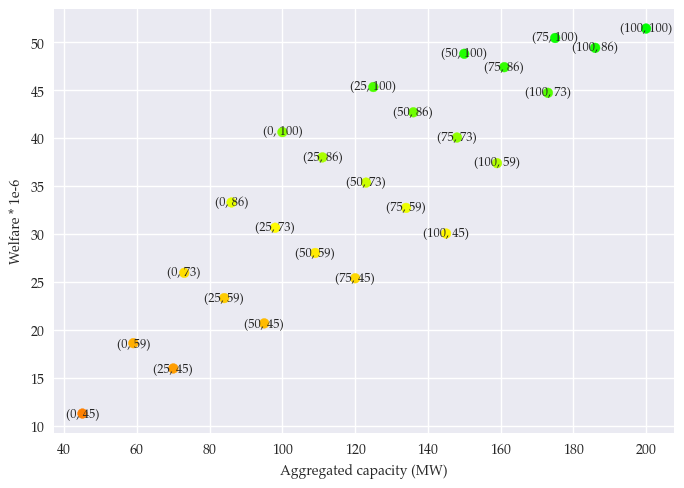

In [1447]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, Normalize

# Din DataFrame
tabel_df = pd.DataFrame(tabel_data)

# Gange velfærdsværdierne med 1e-7
tabel_df['velfaerd'] *= 1e-6

# Normaliser velfærdsværdierne mellem 0 og 1 for at bruge dem som farvegradering
norm_velfaerd = Normalize(vmin=tabel_df['velfaerd'].min(), vmax=tabel_df['velfaerd'].max())(tabel_df['velfaerd'])

# Definér en tilpasset farvegradient fra orange til grøn
colors = [(1, 0.5, 0), (1, 1, 0), (0, 1, 0)]  # RGB-værdier for orange, gul og grøn
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

# Lav et scatter plot med farvede punkter
plt.scatter(tabel_df['Samlet capacitet'], tabel_df['velfaerd'], c=norm_velfaerd, cmap=cmap)

# Tilføj kombinationstekst til hvert punkt
for i, row in tabel_df.iterrows():
    combination_text = f"({row['Combination'][0]}, {row['Combination'][1]})"
    
    # Juster y-koordinaten baseret på velfærdsværdien
    if row['Combination'] == (55, 86):
        y_coord = row['velfaerd'] - 2e-7
    else:
        y_coord = row['velfaerd'] + 1e-7 if row['velfaerd'] == tabel_df['velfaerd'].max() else row['velfaerd'] - 1e-7
    
    plt.text(row['Samlet capacitet'], y_coord, combination_text, fontsize=9, ha='center', va='center')

# Tilføj aksetitler
plt.xlabel('Aggregated capacity (MW)')
plt.ylabel('Welfare * 1e-6')

# Vis grafen
plt.show()


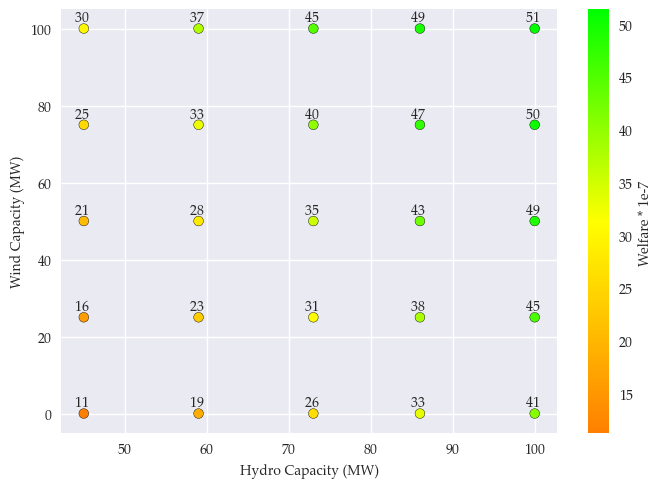

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

# Assuming df is your DataFrame
tabel_df = pd.DataFrame(tabel_data)

# Extract x and y values
combinations = tabel_df['Combination']
welfare = tabel_df['velfaerd'] / 1e6  # Convert welfare values to millions

# Unpack the tuples in the 'Combination' column
y, x = zip(*combinations)

# Define a custom colormap from orange to green
colors = [(1, 0.5, 0), (1, 1, 0), (0, 1, 0)]  # RGB values for orange, yellow, and green
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

# Normalize welfare values to the range [0, 1] for the colormap
norm = Normalize(vmin=welfare.min(), vmax=welfare.max())

# Create a scatter plot with swapped x and y, using the custom colormap
plt.scatter(x, y, c=welfare, cmap=cmap, norm=norm, marker='o', edgecolors='black')

# Add labels and a colorbar
plt.xlabel('Hydro Capacity (MW)')
plt.ylabel('Wind Capacity (MW)')
cbar = plt.colorbar()
cbar.set_label('Welfare * 1e-7 ')

# Add welfare value annotations for each combination
for i, (xi, yi, wi) in enumerate(zip(x, y, welfare)):
    plt.annotate(f'{wi:.0f} ', (xi, yi), textcoords="offset points", xytext=(0, 5), ha='center')

# Show the plot
plt.show()


### _Opdateres manuelt_, part to

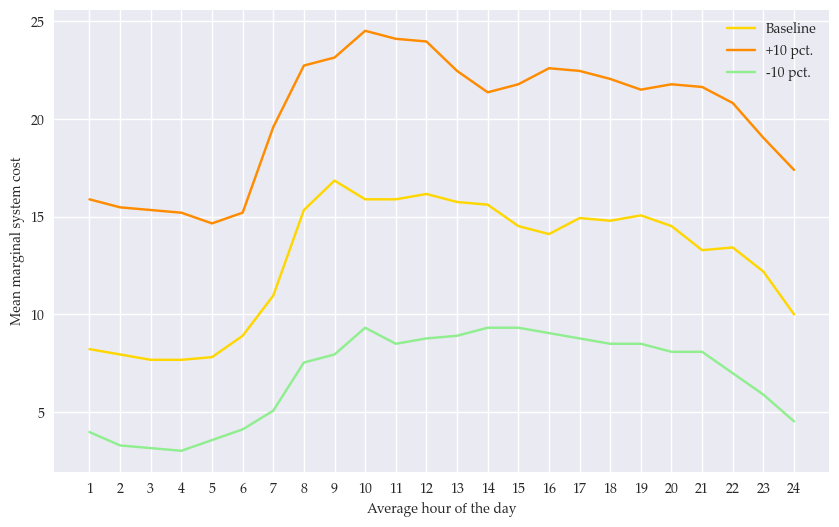

In [ ]:
data_load = {
    'hour': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
    'Baseline': [
    8.219179753424658,
    7.945207161643836,
    7.671234569863014,
    7.671234569863014,
    7.808220865753424,
    8.904111232876712,
    10.958905671232877,
    15.342467139726029,
    16.84931639452055,
    15.890412323287672,
    15.890412323287672,
    16.164384915068492,
    15.75342602739726,
    15.61643973150685,
    14.52054936438356,
    14.109590476712329,
    14.931508252054794,
    14.794521956164385,
    15.068494547945205,
    14.52054936438356,
    13.287672701369862,
    13.424658997260273,
    12.191782334246577,
    10.0000016],

'+10 pct.': [
    15.890412323287672,
    15.479453435616437,
    15.342467139726029,
    15.205480843835616,
    14.657535660273973,
    15.205480843835616,
    19.58904231232877,
    22.73972711780822,
    23.15068600547945,
    24.52054896438356,
    24.10959007671233,
    23.972603780821917,
    22.465754526027396,
    21.369864158904107,
    21.780823046575343,
    22.60274082191781,
    22.465754526027396,
    22.054795638356165,
    21.50685045479452,
    21.780823046575343,
    21.643836750684933,
    20.821918975342463,
    19.041097128767124,
    17.397261578082194],

'-10 pct.' :[
    3.9726045808219177,
    3.2876731013698635,
    3.1506868054794523,
    3.0137005095890412,
    3.5616456931506852,
    4.109590876712328,
    5.068494947945205,
    7.534248273972602,
    7.945207161643836,
    9.315070120547945,
    8.49315234520548,
    8.767124936986301,
    8.904111232876712,
    9.315070120547945,
    9.315070120547945,
    9.041097528767123,
    8.767124936986301,
    8.49315234520548,
    8.49315234520548,
    8.082193457534245,
    8.082193457534245,
    6.98630309041096,
    5.890412723287672,
    4.520549764383562]
}



# Definér farver for hvert datasæt baseret på værdierne
color_dict = {'+10 pct.': 'darkorange', 'Baseline': 'gold', '-10 pct.': 'lightgreen'}

# Plotting
plot_msc = plt.figure(figsize=(10, 6))

for key, values in data_load.items():
    if key != 'hour':
        plt.plot(data_load['hour'], values, label=key, color=color_dict[key])


plt.xlabel('Average hour of the day')
plt.xticks(range(1, 25))
plt.ylabel('Mean marginal system cost')

plt.grid(True)
plt.legend()
plt.show()

### _Opdateres manuelt_, part 3

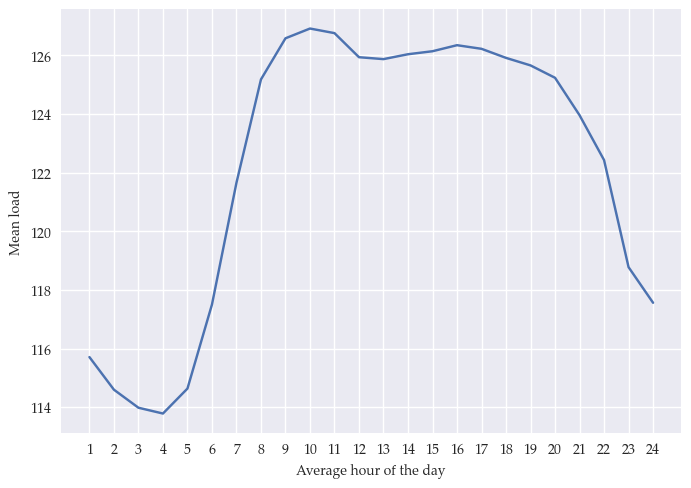

In [1489]:
import matplotlib.pyplot as plt

# Consumption pattern data
consumptionpattern = {
    'hours': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
    'load': [
        115.7087046, 114.5958371, 113.9806818, 113.7827334, 114.6345112, 117.5011317,
        121.6574156, 125.1818119, 126.5846564, 126.9177274, 126.7611366, 125.9391932,
        125.8741575, 126.0408509, 126.1432978, 126.3494546, 126.2256974, 125.9163044,
        125.6594767, 125.2370606, 123.9604989, 122.4299509, 118.7768816, 117.5619053
    ]
}

# Create a line plot
plt.plot(consumptionpattern['hours'], consumptionpattern['load'])
plt.xlabel('Average hour of the day')
plt.xticks(range(1, 25))

plt.ylabel('Mean load')
plt.grid(True)
plt.show()
